In [68]:
using FeedbackParticleFilters

using StatsBase
using LinearAlgebra
using PyPlot
using Profile

# Single gain computation

In [3]:
# numerical integral over R by transform
function finv(y::Float64)
    return tan(pi*y/2)#log((1+y)/(1-y))
end

function finvprime(y::Float64)
    return pi/(1+cos(pi*y))#2/(1-y^2)
end

function NumIntR(fun::Function, n::Int64)
    x = zeros(Float64, n+1)
    int = zeros(Float64, n+1)
    dy = 2. / (n+1)
    y = -1. -dy/2
    for i = 2:(n+1)
        y = y + dy
        x[i] = finv(y)
        int[i] = int[i-1] + fun(x[i]) * dy * finvprime(y)
    end
    x[2:n+1], int[2:n+1]
end;

In [4]:
# Settings
function p(x::Float64)
    ( exp(-(x-1)^2/(2*0.16))+exp(-(x+1)^2/(2*0.16)) ) / sqrt(8*pi*0.16)
end;

function h(x::Float64)
    x
end;

In [5]:
hbar = NumIntR(x -> h(x)*p(x),1000)[2][end]

-6.876696392728779e-16

In [64]:
xx,int = NumIntR(x -> -(h(x)-hbar)*p(x),1000);
K_exact = int ./ p.(xx);

In [200]:
function NewSolve!(eq::ScalarPoissonEquation, method::SemigroupMethod1d) 
    N = length(eq.positions)
    H = copy(eq.H)
    broadcast!(-, H, H, eq.mean_H)   
    broadcast!(*, H, H, method.epsilon)

    # compute T operator
    T = zeros(Float64, N, N)
    @inbounds for i in 1:N
        @inbounds for j in i:N
            T[i,j] = exp(-(eq.positions[i]-eq.positions[j])^2/(4*method.epsilon))
            T[j,i] = T[i,j]
        end
    end
    broadcast!(/, T, T, sqrt.(sum(T,dims=1) .* sum(T,dims=2)))
    broadcast!(/, T, T, sum(T,dims=2))

    # solve fixed-point equation
    newpotential = copy(eq.potential)::Array{Float64,1}
    fluctuation = 1.
    while fluctuation > method.delta
        LinearAlgebra.mul!(newpotential, T, eq.potential)
        broadcast!(+, newpotential, newpotential, H)
        broadcast!(-, newpotential, newpotential, StatsBase.mean(newpotential))
        fluctuation = maximum(abs.(newpotential-eq.potential))
        eq.potential = copy(newpotential)
    end

    @time eq.gain = T * (eq.potential .* eq.positions) - (T*eq.potential) .* (T*eq.positions)
    @time LinearAlgebra.mul!(eq.gain, T, eq.potential .* eq.positions)
    @time 
    broadcast!(/, eq.gain, eq.gain, 2*method.epsilon)
end;

In [201]:
N=1000
positions=vcat(0.4.*randn(div(N,2)).-1,0.4.*randn(div(N,2)).+1)
testens=FPFEnsemble(positions,N);
eq=ScalarPoissonEquation(h, testens);

In [202]:
@time NewSolve!(eq, SemigroupMethod1d(0.1,1E-2));

  0.000177 seconds (6 allocations: 47.625 KiB)
  0.000054 seconds (1 allocation: 7.938 KiB)
  0.128574 seconds (259.48 k allocations: 28.550 MiB, 1.55% gc time)


In [167]:
@time Update!(eq, testens);

  0.000004 seconds (5 allocations: 176 bytes)


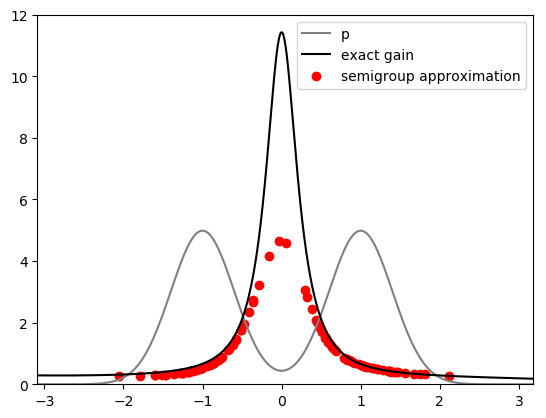

In [70]:
xlim((1.5*minimum(testens.positions),1.5*maximum(testens.positions)))
ylim((0,12))
plot(xx, 10*p.(xx), color="gray");
plot(xx, K_exact, color="black");
scatter(eq.positions, eq.gain, color="red");
#scatter(testens.positions, testens.potential)
#hist(testens.positions,50)
legend(("p","exact gain","semigroup approximation"));

# Loop

In [26]:
# simulate sequential gain estimation and update
N=1000
positions=vcat(0.4.*randn(div(N,2)).-1,0.4.*randn(div(N,2)).+1)
testens=FPFEnsemble(positions,N);
eq=ScalarPoissonEquation(x->h(x), testens);
n_time = 100 # number of time steps
positions = zeros(n_time,N)
potentials = zeros(n_time,N)
gains = zeros(n_time,N)
@timev for i = 1:n_time
    Update!(eq, testens)
    Solve!(eq, SemigroupMethod1d(0.1,0.01))
    positions[i,:] = testens.positions
    #testens.gain_data.potential = eq.potential
    #testens.gain_data.gain = eq.gain
    potentials[i,:] = eq.potential
    gains[i,:] = eq.gain
    ApplyGain!(testens, eq, 1E-2)
end

  1.275566 seconds (43.47 k allocations: 1.517 GiB, 5.10% gc time)
elapsed time (ns): 1275565657
gc time (ns):      65115479
bytes allocated:   1628727111
pool allocs:       39970
non-pool GC allocs:3300
malloc() calls:    200
GC pauses:         67


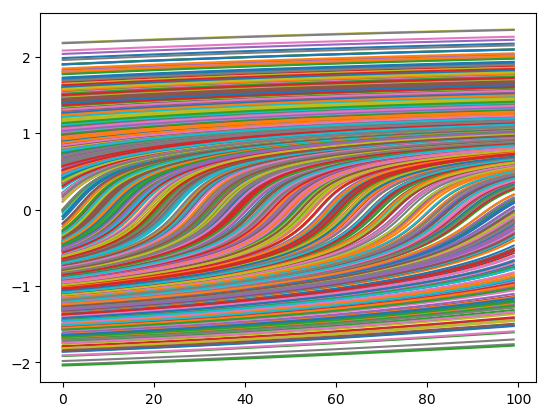

In [21]:
plot(positions[:,:]);

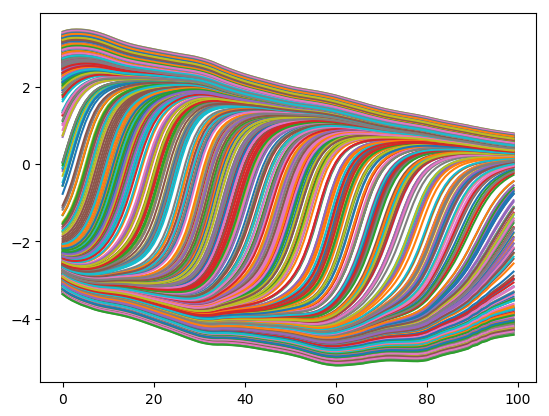

In [22]:
plot(potentials[:,:]);

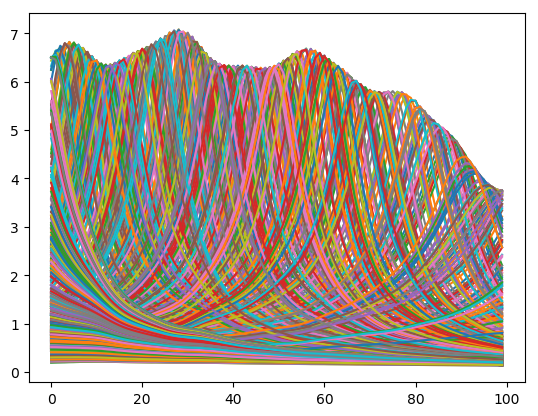

In [23]:
plot(gains[:,:]);